In [ ]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=annot, cmap="rocket_r", fmt="", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

In [ ]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=true, cmap="rocket_r", fmt=".2g", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

In [ ]:
df = load_dataset(Skripal)

In [2]:
using StatsBase
include("../Engine/Engine.jl")
using .Engine
import PyPlot as plt
import Seaborn as sns

In [14]:
df = load_dataset(Skripal)
df = skripal_dates(df);
df = trust_score(df);
f, _ = IP_scores(by_partition=false)
df = f(df);

x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

users[1:20]

In [11]:
df2 = load_dataset(COP26)
df2 = cop_26_dates(df2)
f, _ = IP_scores(actor_number="all_positive", aggregate_size=100000000)
df2 = f(df2)

combine(groupby(df2, "partition"), "actor" => (x->length(unique(x))) => "count")

,partition,count
,String,Int64
1,Before COP26,952
2,During COP26,1014
3,After COP26,441


In [23]:
df2 = load_dataset(COP26)
df2 = cop_26_dates(df2)
f, _ = IP_scores(actor_number="all", aggregate_size=100000000)
df2 = f(df2)

combine(groupby(df2, "partition"), "actor" => (x->length(unique(x))) => "count")

,partition,count
,String,Int64
1,Before COP26,4841
2,During COP26,5508
3,After COP26,2368


In [27]:
x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

5965-element Vector{Float64}:
 0.056722024501845054
 0.03627213175162406
 0.035667320634799576
 0.02815227286901304
 0.022586439134173044
 0.02228551342037563
 0.020304109529197343
 0.019858284452969905
 0.01701881819655281
 0.013578912814905999
 0.013517665731812132
 0.012026848460675737
 0.011599367373026498
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [25]:
sum(df2.I_score .> 0)

30388

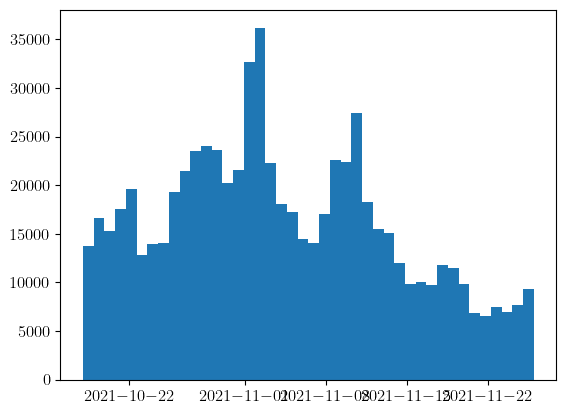

([13743.0, 16619.0, 15294.0, 17552.0, 19598.0, 12760.0, 13952.0, 14055.0, 19309.0, 21450.0  …  9688.0, 11761.0, 11502.0, 9856.0, 6889.0, 6576.0, 7479.0, 6910.0, 7665.0, 9291.0], [18918.0, 18918.928570601853, 18919.857141203705, 18920.785711805554, 18921.714282407407, 18922.64285300926, 18923.571423611113, 18924.49999421296, 18925.428564814814, 18926.357135416667  …  18948.64282986111, 18949.571400462963, 18950.499971064815, 18951.428541666664, 18952.357112268517, 18953.28568287037, 18954.214253472222, 18955.14282407407, 18956.071394675924, 18956.999965277777], (PyObject <matplotlib.patches.Rectangle object at 0x36919ceb0>, PyObject <matplotlib.patches.Rectangle object at 0x36919d030>, PyObject <matplotlib.patches.Rectangle object at 0x36919d3f0>, PyObject <matplotlib.patches.Rectangle object at 0x36919d630>, PyObject <matplotlib.patches.Rectangle object at 0x36919d810>, PyObject <matplotlib.patches.Rectangle object at 0x36919d9f0>, PyObject <matplotlib.patches.Rectangle object at 0x369

In [20]:
import PyPlot as plt

plt.hist(df2.created_at, bins=42)

df = co

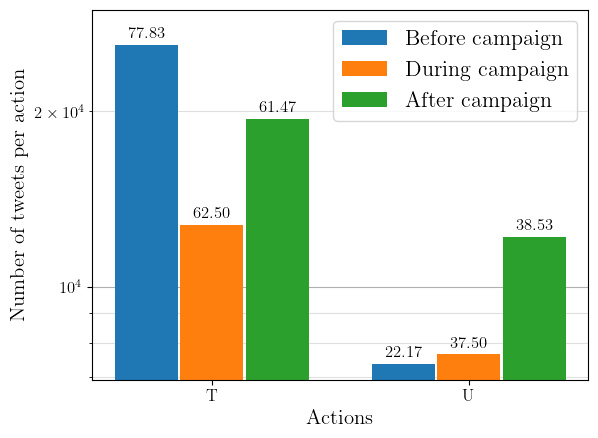

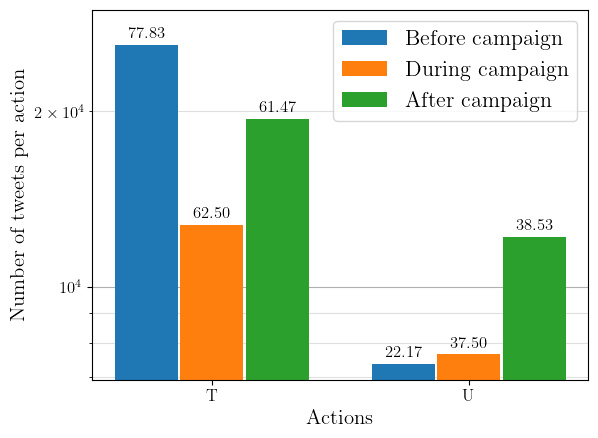

In [9]:
plot_action_frequency(df)

In [21]:
x = rand(0:1, 200);

In [22]:
using CausalityTools
import Random
Random.seed!(12)

surros = []
generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros, copy(generator()))
end

generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros, copy(generator()))
end

In [26]:
using Dates

DateTime(2018, 04, 08, 01, 00, 00) > Date(2018, 04, 8)

true

In [23]:
Random.seed!(12)

surros2 = []
generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros2, copy(generator()))
end

generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros2, copy(generator()))
end

In [10]:
# f1, _ = IP_scores(by_partition=true, actor_number="all")
f2, _ = all_users(by_partition=true)

# df1 = f1(df)
df2 = f2(df);

In [11]:
unique(df2.username)

1921-element Vector{String}:
 "ECOWARRIORSS"
 "SierraClub"
 "MotherJones"
 "MythicVenom22"
 "C_Smart_Climate"
 "TheRealNews"
 "marinccl"
 "EarthAccounting"
 "friends_earth"
 "heather_reams"
 "Giacomo_Cortes"
 "GeogResearch"
 "ClimateHuman"
 ⋮
 "TedGrunewald"
 "UncleChopperRIP"
 "CarbonCreditRes"
 "DavidVio2"
 "clirater"
 "jtparsons8"
 "jasonrantz"
 "healthierphilly"
 "McbainePsy"
 "BlondieClimate"
 "mrfunnysmart"
 "IrishSchSusty"

In [8]:
df1[:, Not(["I_score", "P_score", "retweet_from"])] == df2[:, Not(["tweet_count", "retweet_from"])]

true

In [7]:
names(df1)

11-element Vector{String}:
 "partition"
 "created_at"
 "effective_category"
 "domain"
 "sentiment"
 "username"
 "follower_count"
 "retweet_from"
 "I_score"
 "P_score"
 "actor"

In [3]:
f1, _ = IP_scores(by_partition=true, min_tweets=3)
df1 = f1(df)
df1 = df1[:, Not("retweet_from")]
df1 = select(df1, sort(names(df1)));

In [5]:
combine(groupby(df1, "partition"), "username" => (x->length(unique(x))) => "count")

,partition,count
,String,Int64
1,Before COP26,4841
2,During COP26,5508
3,After COP26,2368


In [4]:
f2, _ = IP_scores(by_partition=false, min_tweets=3)

dfs = []
for partition in unique(df.partition)
    push!(dfs, f2(df[df.partition .== partition, :]))
end
df2 = vcat(dfs...)[:, Not("retweet_from")]
df2 = select(df2, sort(names(df2)));

In [5]:
df1 == df2

false

In [ ]:
using BenchmarkTools
using CausalityTools

igg = InfluenceGraphGenerator(Engine.JointDistanceDistribution, surrogate=nothing)

f = (x,y) -> pvalue(jdd(OneSampleTTest, x, y, B=10, D=5, τ=1, μ0=0.0), tail=:right) < 0.001 ? 1 : 0
f2 = (x,y) -> igg.causal_function(x,y)

x = rand(600)
y = rand(600)

@btime f2(x,y)

In [ ]:
regex = r"^AGG[0-9]+:"
a = "AGG1678934: joeoepzocnjocz    dveonoze^12"
if occursin(regex, a)
    print("cool")
else
    print("prout")
end

In [ ]:
df1 = transform(groupby(df1, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")
df2 = transform(groupby(df2, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")
df3 = transform(groupby(df3, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")

In [ ]:
df1 = df1[df1.tweet_count .>= 3, :]
df2 = df2[df2.tweet_count .>= 3, :]
df3 = df3[df3.tweet_count .>= 3, :]

In [ ]:
length(unique(df2.username))

In [ ]:
plot_action_frequency(df2)

In [ ]:
length(unique(df2.username))

In [ ]:
tweet_count = combine(groupby(tweeters, "username"), "created_at" => length => "count")
tweet_count = tweet_count[tweet_count.count .>= 3, :]
nodes = tweet_count.username

In [ ]:
"GretaThunberg" in nodes

In [ ]:
using Dates

df = load_dataset(COP26)

df = df[.~ismissing.(df."domain"), :]
if eltype(df."created_at") == String
    to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
    df."created_at" = to_datetime.(df."created_at")
end

df = PreProcessing.cop_26_dates(df)
df = PreProcessing.trust_score(df)
df = transform(groupby(df, "username"), "created_at" => length => "count")

tweeters = df[df.effective_category .== "tweet", :]
retweeters = df[df.effective_category .== "retweet", :]

bad_df = df[df.action .== "U", :]
good_df = df[df.action .== "T", :]

weights, u, v, nodes = PreProcessing.IP_graph(df, min_tweets=3)

I, P, residuals = PreProcessing.IP_scores(u, v)

# Sort in the order of most influence
sorting = sortperm(I, rev=true)
nodes = nodes[sorting]
I = I[sorting]
P = P[sorting]

# Extract dataframes of 500 most influentials according to I score
isin = (x,y) -> x in y
influentials = tweeters[isin.(tweeters.username, Ref(nodes[1:500])), :]
foo = combine(groupby(influentials, "username"), "action" => (x -> sum(x .== "U")) => "U_count")

bad_users = foo.username[foo.U_count .> 0]
bad_users_rank = [findall(user .== nodes) for user in bad_users];

In [ ]:
nodes_bad[1:20]

In [ ]:
# I_normal = I
# P_normal = P
# nodes_normal = nodes

test_normal = nodes_normal[I_normal .> 0];

In [ ]:
# I_bad = I
# P_bad = P
# nodes_bad = nodes

test_bad = nodes_bad[I_bad .> 0];

In [ ]:
a = [[1, 2], [3, 4]]

In [ ]:
foo = @view a[1]

In [ ]:
foo2 = a[2]

In [ ]:
foo[1]

In [ ]:
a[1][1] = 2
a

In [ ]:
isin = (x,y) -> x in y
# sum(isin.(nodes_bad[1:500], Ref(nodes_normal[1:500])))

sum(isin.(test_bad, Ref(test_normal))) 

In [ ]:
sum(I_normal .> 0)

In [ ]:
(12200 - 500) / 100

In [ ]:
sorting = sortperm(P, rev=true)
nodes = nodes[sorting]
I = I[sorting]
P = P[sorting]

In [ ]:
nodes

In [ ]:
I0 = I .== 0
P0 = P .== 0

I1 = I .!= 0
P1 = P .!= 0;

# sort(I0) == sort(P1)

In [ ]:
sum(I1 .&& P0)

In [ ]:
sum(I1 .|| P1) / length(I0)

In [ ]:
I

In [ ]:
nodes

In [ ]:
test = tweeters[tweeters.action .== "U", :]
test = transform(groupby(test, "username"), "created_at" => length => "Ucount")

length(unique(test[test.Ucount .>= 2, "username"]))

In [ ]:
nodes[123]

In [ ]:
length(residuals)

In [ ]:
res_ = residuals
plt.figure()
plt.plot(1:length(res_), res_)
plt.yscale("log")


In [ ]:
initial_actors = unique(test[ismissing.(test.rt_from), "username"])
counter = []

rts = test[.!ismissing.(test.rt_from), :]
# mapping = countmap(rts)
# transform(groupby(df, "username"), "created_at" => length => "tweet_count")

for (i, a) in enumerate(initial_actors)
    indices = findall(rts.rt_from .== a)
    push!(counter, rts.username[indices])
    # counter[i] = sum(rts.rt_from .== a)
end

In [ ]:
N = [length(i) for i in counter]
sorting = sortperm(N, rev=true)
N = N[sorting]
initial_actors = initial_actors[sorting]
counter = counter[sorting]

In [ ]:
counter[1]

In [ ]:
initial_actors[1:30]

In [ ]:
initial_actors = unique(test[ismissing.(test.rt_from), "username"]);

In [ ]:
using BenchmarkTools

counter = []

@btime begin
    indices = findall(rts.rt_from .== initial_actors[1])
    push!(counter, rts.username[indices])
end

In [ ]:
# foo = test[test.category .== Ref(["tweeted"]), :]
# foo = transform(groupby(foo, "username"), "created_at" => length => "tweet_count")
# foo = foo[foo.tweet_count .>= 1, :]
# length(unique(foo.username))


initial_actors = unique(test[.ismissing.(test.rt_from), "username"])

In [ ]:
sum(.!ismissing.(test.rt_from))

In [ ]:
foo = test[startswith.(test.text, Ref("RT @")) .&& test.category .!= Ref(["retweeted"]), :]

In [ ]:
show(foo, allcols=true)

In [ ]:
find_user(test.text[1])

In [ ]:
length(unique(test.username))

In [ ]:
sum(test.category .== Ref(["quoted"]))

In [ ]:
followers[500]

In [ ]:
sum(followers .== 0)

In [ ]:
261259/50

## DECREASE BINS LOGARITHMICALLY

In [ ]:
25929^2/520^2*10/60/60

In [ ]:
sum(0 .< followers .< 50)

In [ ]:
sum(followers .== 0)

In [ ]:
sum(followers .> 500000)

In [ ]:
test = collect(1:10)
sorting = sortperm(test, rev=true)
test[sorting]